In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
import warnings

In [153]:
warnings.filterwarnings("ignore")

In [154]:
# Load dataset
df = pd.read_csv('./covid19.csv')
df

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,female,returned home,03/05/2020,NaN,1.0,65,2.0,2.0,...,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,3,NaN
1,2,1,male,returned home,03/06/2020,NaN,1.0,72,NaN,2.0,...,2.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,5,NaN
2,2,1,male,hospitalization,09/06/2020,1.0,2.0,55,NaN,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3,2.0
3,2,1,female,returned home,12/06/2020,NaN,2.0,53,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,7,NaN
4,2,1,male,returned home,21/06/2020,NaN,2.0,68,NaN,1.0,...,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,2,13,male,returned home,9999-99-99,NaN,2.0,40,NaN,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,7,NaN
1048571,1,13,male,hospitalization,9999-99-99,2.0,2.0,51,NaN,2.0,...,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,7,2.0
1048572,2,13,male,returned home,9999-99-99,NaN,2.0,55,NaN,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,7,NaN
1048573,2,13,male,returned home,9999-99-99,NaN,2.0,28,NaN,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,7,NaN


In [155]:
def preprocess_data(df):
    # Change 'SEX' to numerical value
    sex_mapping = {'female': 0, 'male': 1}
    df['SEX'] = df['SEX'].map(sex_mapping)
    
    # Change 'PATIENT_TYPE' to numerical value
    ptype_mapping = {'returned home': 0, 'hospitalization': 1}
    df['PATIENT_TYPE'] = df['PATIENT_TYPE'].map(ptype_mapping)
    
    # Drop rows with NaN 
    columns_to_dropna = ['PREGNANT', 'ICU', 'DIABETES', 'PATIENT_TYPE', 'INTUBED']
    df_clean = df.dropna(subset=columns_to_dropna)
    
    # Convert 'DATE_DIED' to binary values
    df_clean['DATE_DIED'] = df_clean['DATE_DIED'].apply(lambda x: 0 if x != '9999-99-99' else 1)
    
    # Imputation using IterativeImputer
    imput = IterativeImputer()
    missing_icu = df.columns[df.isnull().any() & df.columns.str.contains('ICU')]
    df[missing_icu] = imput.fit_transform(df.loc[:,missing_icu])
    missing_pregnant = df.columns[df.isnull().any() & df.columns.str.contains('PREGNANT')]
    df[missing_pregnant] = imput.fit_transform(df[missing_pregnant])
    missing_intubed = df.columns[df.isnull().any() & df.columns.str.contains('INTUBED')]
    df[missing_intubed] = imput.fit_transform(df[missing_intubed])
    
    
    return df_clean

In [156]:
def visualize_data(df):
    # Histograms
    columns_to_plot = ['AGE', 'SEX', 'ASTHMA', 'CARDIOVASCULAR', 'PATIENT_TYPE', 'ICU', 'CLASIFFICATION_FINAL', 'OTHER_DISEASE']
    plt.figure(figsize=(10, 8))
    for i, col in enumerate(columns_to_plot, 1):
        plt.subplot(3, 3, i)
        plt.hist(df[col])
        plt.title(col)
    
    # Correlation heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(df.corr(), annot=True)
    plt.title('Correlation Heatmap')

In [157]:
def train_random_forest(df):
    X = df.drop(['DATE_DIED', 'SEX'], axis=1)
    y = df['DATE_DIED']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50, shuffle=True)
    
    rf = RandomForestClassifier(n_estimators=100, random_state=50)
    rf.fit(X_train, y_train)
    
    rf_pred = rf.predict(X_test)
    rf_score = accuracy_score(y_test, rf_pred)
    rf_report = classification_report(y_test, rf_pred)
    
    cm = confusion_matrix(y_test, rf_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt=".6g")
    plt.title('Confusion Matrix')
    
    return rf_score, rf_report

In [158]:
def train_xgboost(df):
    X = df[['USMER', 'MEDICAL_UNIT', 'SEX', 'PATIENT_TYPE', 'INTUBED', 'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES',
            'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC',
            'TOBACCO']]
    y = df['DATE_DIED']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=50, shuffle=True)
    
    xgb = XGBClassifier()
    xgb.fit(X_train, y_train)
    
    xgb_pred = xgb.predict(X_test)
    xgb_score = accuracy_score(y_test, xgb_pred)
    xgb_report = classification_report(y_test, xgb_pred)
    
    cm = confusion_matrix(y_test, xgb_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt=".6g")
    plt.title('Confusion Matrix')
    
    return xgb_score, xgb_report

In [159]:
def check_nan(df):
    nan_columns = df.columns[df.isna().any()].tolist()
    nan_count = df.isna().sum().to_frame('Count').sort_values('Count', ascending=False)
    nan_percentage = (nan_count / len(df)) * 100
    nan_percentage.columns = ['Percentage']
    
    print("Columns with NaN values:")
    print(nan_columns)
    print("\nNaN Value Count:")
    print(nan_count)
    print("\nNaN Value Percentage:")
    print(nan_percentage)

In [160]:
check_nan(df)

Columns with NaN values:
['INTUBED', 'PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'ICU']

NaN Value Count:
                       Count
ICU                   856032
INTUBED               855869
PREGNANT              527265
PNEUMONIA              16003
OTHER_DISEASE           5045
INMSUPR                 3404
DIABETES                3338
TOBACCO                 3220
HIPERTENSION            3104
CARDIOVASCULAR          3076
OBESITY                 3032
RENAL_CHRONIC           3006
COPD                    3003
ASTHMA                  2979
MEDICAL_UNIT               0
AGE                        0
DATE_DIED                  0
PATIENT_TYPE               0
SEX                        0
CLASIFFICATION_FINAL       0
USMER                      0

NaN Value Percentage:
                      Percentage
ICU                    81.637651
INTUBED                81.622106
PREGNANT              

In [161]:
# Preprocess data
df_clean = preprocess_data(df)

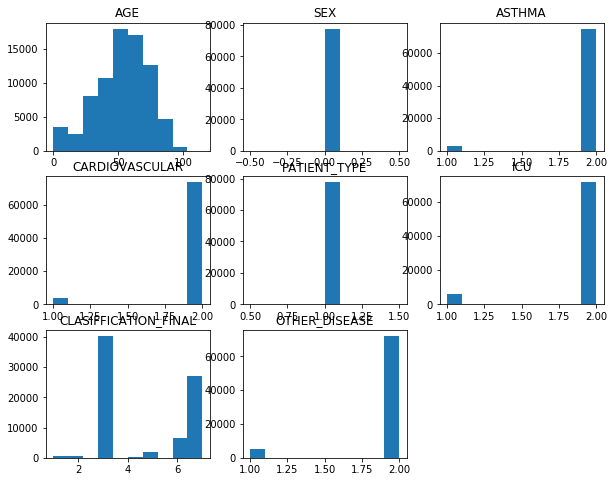

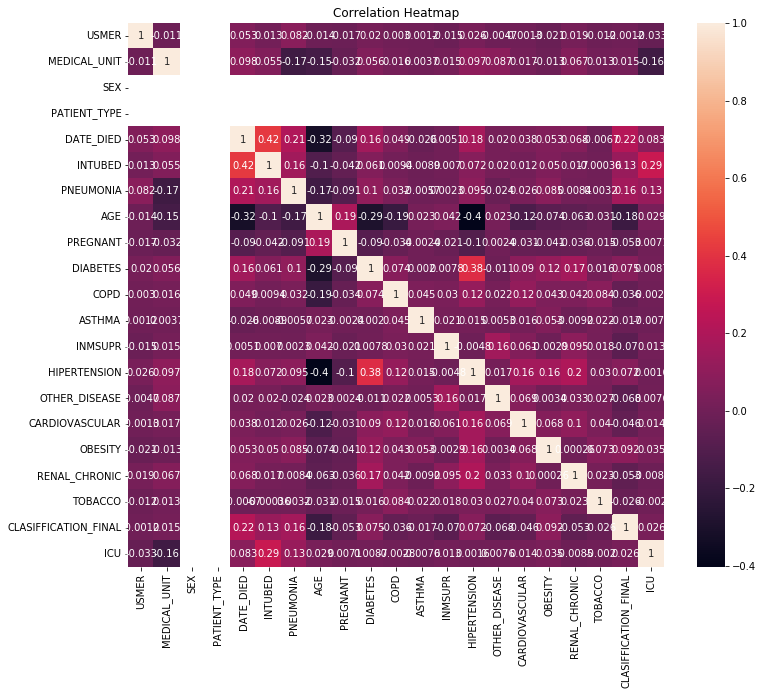

In [162]:
# Visualize data
visualize_data(df_clean)

In [163]:
# Train and evaluate Random Forest model
rf_score, rf_report = train_random_forest(df_clean)
print("Random Forest Accuracy:", rf_score)
print("Random Forest Report:")
print(rf_report)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
# Train and evaluate XGBoost model
xgb_score, xgb_report = train_xgboost(df_clean)
print("XGBoost Accuracy:", xgb_score)
print("XGBoost Report:")
print(xgb_report)